In [129]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
import PIL.Image
from io import StringIO
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
import time
from tf_conversions import posemath
import utils

In [130]:
rospy.init_node('notebook')
rospy.get_published_topics()

[['/rosout_agg', 'rosgraph_msgs/Log'],
 ['/rosout', 'rosgraph_msgs/Log'],
 ['/dvrk/PSM1/set_desired_state', 'std_msgs/String'],
 ['/dvrk/PSM1/set_position_joint', 'sensor_msgs/JointState'],
 ['/dvrk/PSM1/set_position_goal_joint', 'sensor_msgs/JointState'],
 ['/dvrk/PSM1/set_position_cartesian', 'geometry_msgs/Pose'],
 ['/dvrk/PSM1/set_position_goal_cartesian', 'geometry_msgs/Pose'],
 ['/dvrk/PSM1/set_effort_joint', 'sensor_msgs/JointState'],
 ['/dvrk/PSM1/set_wrench_body', 'geometry_msgs/Wrench'],
 ['/dvrk/PSM1/set_wrench_body_orientation_absolute', 'std_msgs/Bool'],
 ['/dvrk/PSM1/set_wrench_spatial', 'geometry_msgs/Wrench'],
 ['/dvrk/PSM1/set_gravity_compensation', 'std_msgs/Bool'],
 ['/dvrk/PSM1/set_position_jaw', 'sensor_msgs/JointState'],
 ['/dvrk/PSM1/set_position_goal_jaw', 'sensor_msgs/JointState'],
 ['/dvrk/PSM1/set_effort_jaw', 'sensor_msgs/JointState'],
 ['/dvrk/PSM1/set_tool_present', 'std_msgs/Bool'],
 ['/dvrk/PSM2/set_desired_state', 'std_msgs/String'],
 ['/dvrk/PSM2/set_p

In [131]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_raw', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_raw', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

while left_image is None or right_image is None:
    time.sleep(0.5)

Removing previous callback, only one redirection possible right now
Removing previous callback, only one redirection possible right now
Removing previous callback, only one redirection possible right now
Removing previous callback, only one redirection possible right now


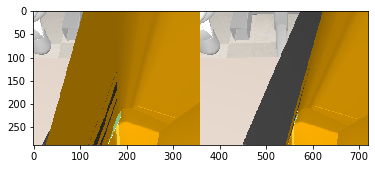

In [132]:
plt.imshow(np.hstack((left_image, right_image)))

In [133]:
tf_listener = tf.TransformListener()
time.sleep(1)
tf_listener.getFrameStrings()

['PSM1_psm_base_link',
 'PSM1_tool_wrist_shaft_link',
 'PSM1_tool_wrist_link',
 'PSM1_tool_tip_link',
 'PSM1_tool_wrist_sca_shaft_link',
 'PSM2_psm_base_link',
 'PSM2_tool_wrist_shaft_link',
 'PSM2_tool_wrist_link',
 'PSM2_tool_wrist_caudier_ee_link',
 'PSM2_tool_wrist_caudier_link_shaft',
 'PSM3_psm_base_link',
 'PSM3_tool_wrist_shaft_link',
 'PSM3_tool_wrist_link',
 'PSM3_tool_wrist_caudier_ee_link',
 'PSM3_tool_wrist_caudier_link_shaft',
 'ecm_base_link',
 'ecm_setup_link',
 'ecm_setup_base_link',
 'ECM',
 'PSM1',
 'PSM2',
 'PSM3',
 'PSM1_base',
 'PSM2_base',
 'PSM3_base',
 'ECM_base',
 'camera',
 'ecm_roll_link',
 'PSM2_tool_wrist_caudier_ee_link_0',
 'PSM2_tool_wrist_caudier_link_2_left',
 'PSM2_tool_wrist_caudier_link_2_right',
 'PSM2_tool_main_link',
 'PSM2_outer_pitch_link',
 'PSM2_outer_yaw_link',
 'PSM2_outer_pitch_back_link',
 'PSM2_outer_pitch_front_link',
 'PSM2_outer_pitch_bottom_link',
 'PSM2_outer_pitch_top_link',
 'PSM2_outer_insertion_link',
 'PSM2_tool_wrist_caudier_

In [134]:
psm1 = dvrk.psm('PSM1')
psm2 = dvrk.psm('PSM2')
psm3 = dvrk.psm('PSM3')
ecm = dvrk.ecm('ECM')
while ecm.get_current_position() == PyKDL.Frame() or ecm.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)
while psm1.get_current_position() == PyKDL.Frame() or psm1.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)

In [ ]:
ECM_STARTING_JOINT_POS = np.asarray([-0.15669435,  0.17855662,  0.07069676,  0.17411496])
#ECM_STARTING_JOINT_POS = np.asarray([0.0615668 , 0.0523214 , 0.04854392, 0.15809197])
#ECM_STARTING_JOINT_POS = np.asarray([-0.14478268, -0.1293848 ,  0.00261061,  0.043541  ])
#ecm.move_joint(ECM_STARTING_JOINT_POS)

while True:
    #ecm.move_joint(np.random.rand(4))
    psm1.move_joint(np.random.rand(6))
    psm2.move_joint(np.random.rand(6))
    psm3.move_joint(np.random.rand(6))

In [147]:
time.sleep(1)
PSM_HOME_POS = np.asarray([0., 0., 0.05, 0., 0., 0.])
psm1.move_joint(PSM_HOME_POS)
psm1.close_jaw()

psm2.move_joint(PSM_HOME_POS)
psm2.close_jaw()

psm3.move_joint(PSM_HOME_POS)
psm3.close_jaw()

True

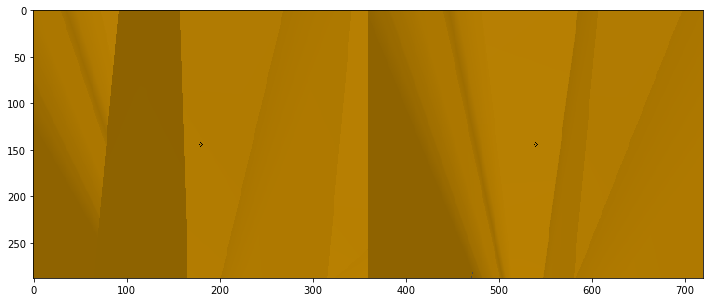

In [143]:
import image_geometry
utils = None
import utils
stereo_model = image_geometry.StereoCameraModel()
stereo_model.fromCameraInfo(left_camera_info, right_camera_info)

tf_cam_to_world = utils.tf_to_pykdl_frame(tf_listener.lookupTransform('simworld', 'simcamera', rospy.Time()))
tf_world_to_psm1 = \
    utils.PSM_J1_TO_BASE_LINK_TF * utils.tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM1', 'simworld', rospy.Time()))
tf_world_to_psm2 = \
    utils.PSM_J1_TO_BASE_LINK_TF * utils.tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM2', 'simworld', rospy.Time()))

objects, frame = utils.get_points_and_img(left_image_msg, right_image_msg, stereo_model, tf_cam_to_world)
plt.figure(figsize=(12, 5))
plt.imshow(frame)
for o in objects:
    o = PyKDL.Vector(o.x(), o.y(), o.z() - 0.005)

In [144]:
len(objects)

0

In [145]:
# pair up points that are across from each other
# x is *more or less* the axis along the wound
paired_pts = []
while objects:
    pt = objects[0]
    objects.remove(pt)
    print(objects)
    pt2 = min(objects, key=lambda obj : abs(obj.x() - pt.x()))
    objects.remove(pt2)
    paired_pts.append(
        (max(pt, pt2, key=lambda p: p.y()), min(pt, pt2, key=lambda p: p.y())))
paired_pts

[]

In [141]:
import suturing_state_machine
from importlib import reload
reload(suturing_state_machine)
reload(utils)

sm1 = suturing_state_machine.SuturingStateMachine(psm1, tf_world_to_psm1, paired_pts[3:])  
sm2 = suturing_state_machine.SuturingStateMachine(psm2, tf_world_to_psm2, paired_pts[:3])
sm3 = suturing_state_machine.SuturingStateMachine(psm3, tf_world_to_psm2, paired_pts[:3])

while not sm1.is_done() or not sm2.is_done() or not sm3.is_done():
    sm1.run_once()
    sm2.run_once()
    sm3.run_once()
    time.sleep(0.1)

[INFO] [1611935494.568732]: Executing state SuturingState.HOME
[INFO] [1611935494.571020]: Executing state SuturingState.HOME
[INFO] [1611935494.576363]: Executing state SuturingState.HOME
[INFO] [1611935494.680033]: Executing state SuturingState.HOME
[INFO] [1611935494.686149]: Executing state SuturingState.HOME
[INFO] [1611935494.688037]: Executing state SuturingState.HOME
[INFO] [1611935494.789209]: Executing state SuturingState.HOME
[INFO] [1611935494.799562]: Executing state SuturingState.HOME
[INFO] [1611935494.800933]: Executing state SuturingState.HOME
[INFO] [1611935494.905909]: Executing state SuturingState.HOME
[INFO] [1611935494.907269]: Executing state SuturingState.HOME
[INFO] [1611935494.908123]: Executing state SuturingState.HOME
[INFO] [1611935495.009338]: Executing state SuturingState.HOME
[INFO] [1611935495.011589]: Executing state SuturingState.HOME
[INFO] [1611935495.016270]: Executing state SuturingState.HOME
[INFO] [1611935495.117940]: Executing state SuturingSta

In [94]:
dir(psm1)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_arm__arm_current_state',
 '_arm__arm_current_state_cb',
 '_arm__arm_current_state_event',
 '_arm__arm_desired_state',
 '_arm__arm_desired_state_cb',
 '_arm__arm_name',
 '_arm__check_input_type',
 '_arm__dmove_frame',
 '_arm__dmove_rotation',
 '_arm__dmove_translation',
 '_arm__effort_joint_current',
 '_arm__effort_joint_desired',
 '_arm__full_ros_namespace',
 '_arm__goal_reached',
 '_arm__goal_reached_cb',
 '_arm__goal_reached_event',
 '_arm__init_arm',
 '_arm__jacobian_body',
 '_arm__jacobian_body_cb',
 '_arm__jacobian_spatial',
 '_arm__jacobian_spatial_cb',
 '_arm__move_cartesian_direct',
 '_arm__move_cartesian_goal',

In [ ]:
ecm.get_current_joint_position()

In [ ]:
psm2.close_jaw()